<a href="https://colab.research.google.com/github/sinaamirrajab/TransformerHackathon/blob/main/pytorch_tutorial_MRS_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sample MRS acceleration Tutorial

This notebook is a tutorial for a simple implementation on how to create a machine learning model to accelerate GABA Edited-MRS

The model we'll use will receive as input difference transients in the frequency domain and output a single difference spectrum. In other words, it's only performing the denoising and combination of the difference transients. An important note is that this is only one of the possible options, the acceleration could also be done with one model per subspectra, or in the time domain, for example.

In [2]:
# Changing path to access scripts
import sys
sys.path.insert(0,"..")

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Verify cuda
torch.cuda.is_available()

True

In [1]:
# Downloading the sample data
!wget 'https://github.com/sinaamirrajab/TransformerHackathon/raw/main/data/sample_data.h5'
!wget 'https://github.com/sinaamirrajab/TransformerHackathon/raw/main/torch_weights.pth'

--2023-02-17 14:53:55--  https://github.com/sinaamirrajab/TransformerHackathon/raw/main/data/sample_data.h5
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sinaamirrajab/TransformerHackathon/main/data/sample_data.h5 [following]
--2023-02-17 14:53:56--  https://raw.githubusercontent.com/sinaamirrajab/TransformerHackathon/main/data/sample_data.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19662848 (19M) [application/octet-stream]
Saving to: ‘sample_data.h5’

sample_data.h5      100%[===================>]  18.75M   119MB/s    in 0.2s    

2023-02-17 14:53:56 (119 MB/s) - ‘sample_data.h5’ saved

### Data Loading

The first thing we'll need to do is loading the data, which is stored as ground truth fids in a numpy file. We'll then add noise to the fids, generating our noisy transients this way.

After obtaining the transients, we'll normalize both the x and y data and divide them into training and testing datasets.

In [4]:
### load sample data
with h5py.File("/content/sample_data.h5") as hf:
    gt_fids = hf["ground_truth_fids"][()]
    ppm = hf["ppm"][()]
    t = hf["t"][()]

# transforming into frequency domain to use as the target data
gt_spec = np.fft.fftshift(np.fft.ifft(gt_fids,axis=1),axes=1)

##################################################################
# adding domain specific imperfections to the ground truth data
##################################################################
####  Adding Noise ####
#Expand to new dimension and add 40 transients per subspectra
noise_fid = np.expand_dims(gt_fids.copy(),axis=3)
noise_fid = np.repeat(noise_fid,40,axis=3)

# Amplitude noise
base_amplitude_noise = 5
amplitude_noise = np.random.normal(0,base_amplitude_noise,size=noise_fid.shape)
noise_fid = noise_fid+amplitude_noise

# frequency noise
freq_shift_std=20
freq_shifts = np.random.normal(0,freq_shift_std,size = (noise_fid.shape[0],1,1,noise_fid.shape[3]))
noise_fid = noise_fid*np.exp(1j*(freq_shifts*t.reshape(t.shape[0],t.shape[1],1,1)*math.pi/2))

# phase noise
phase_shift_std=30
phase_shifts = np.random.normal(0,phase_shift_std,size = (noise_fid.shape[0],1,1,noise_fid.shape[3]))
noise_fid = noise_fid*np.exp(1j*(phase_shifts*np.ones((t.shape[0],t.shape[1],1,1))*math.pi/180))

##################################################################
# Finish adding domain specific imperfections
##################################################################

# Note: The parameters to add noise and the way noise is added directly affects
# the results and the objective is to be as close as possible to in vivo data.

# Transforming time domain noisy transients into frequency domain difference transients
noise_spec = np.fft.fftshift(np.fft.ifft(noise_fid,axis=1),axes=1)
noise_diff_spec = noise_spec[:,:,1,:]-noise_spec[:,:,0,:]

# initial definition of input data (x) and target ground truth data (y)
x = np.real(noise_diff_spec)
y = np.real(gt_spec[:,:,1]-gt_spec[:,:,0]) # editing process in subtraction

##################################################################
# Normalization is key!
##################################################################

x/= np.max(x,axis=1, keepdims=True)
y/= np.max(y,axis=1, keepdims=True)


# expanding dimensions for compatibility with 2D U-NET (this may not needed for 1D model)
x = np.expand_dims(x,axis=3)


# division of training and testing data
x_train = x[:int(x.shape[0]*0.8)]
x_test = x[int(x.shape[0]*0.8):]

y_train = y[:int(y.shape[0]*0.8)]
y_test = y[int(y.shape[0]*0.8):]

ppm_train = ppm[:int(ppm.shape[0]*0.8)]
ppm_test = ppm[int(ppm.shape[0]*0.8):]

# now we will convert the data to torch formats.

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

ppm_train = torch.from_numpy(ppm_train)
ppm_test = torch.from_numpy(ppm_test)


print('training input {}'.format(x_train.shape))
print('training target {}'.format(y_train.shape))
print('well done loading and sorting data...')


training input torch.Size([160, 2048, 40, 1])
training target torch.Size([160, 2048])
well done loading and sorting data...


In [ ]:
# defining dataset and loader
# Simple dataset used to iterate over data
class BasicDataset(Dataset):
    def __init__(self,x,y,ppm):
        super(BasicDataset,self).__init__()

        self.x = x
        self.y = y
        self.ppm = ppm

    def __len__(self):
        return int(self.x.shape[0])

    def __getitem__(self,idx):

        return self.x[idx],self.y[idx],self.ppm[idx]



batch_size =10
train_dataset = BasicDataset(x_train,y_train,ppm_train)
train_dataloader = DataLoader(train_dataset,batch_size,shuffle=True)

print('size of training data is {}'.format(len(train_dataloader)))


size of training data is 16


input shape torch.Size([10, 2048, 40, 1])
target shape torch.Size([10, 2048])


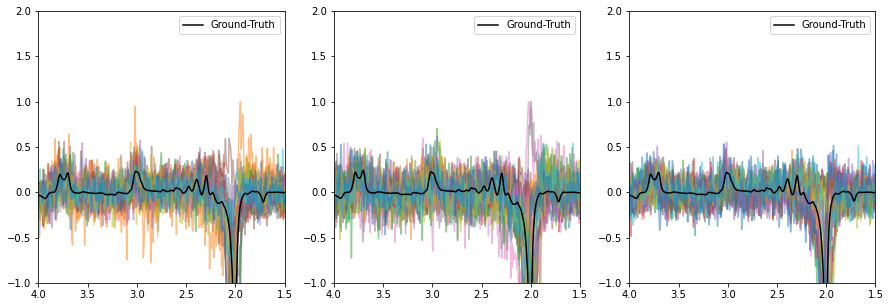

In [ ]:
# visualizing a training batch

x, y, ppm = next(iter(train_dataloader))

print('input shape {}'.format(x.shape))
print('target shape {}'.format(y.shape))



batch = [0,2,6]
how_many_transients = 20
fig,ax = plt.subplots(1,len(batch),figsize=(15,5))
for i in range(len(batch)):
    for j in range(x[batch[i]].shape[-2]):
        if j>how_many_transients:
            break
        ax[i].plot(ppm[batch[i]],np.real(x[batch[i],:,j]),alpha=0.5)
    ax[i].plot(ppm[batch[i]],np.real(y[batch[i],:]),"k-",label="Ground-Truth")
    ax[i].set_xlim(1.5,4)
    ax[i].set_ylim(-1,2)
    ax[i].invert_xaxis()
    ax[i].legend()

plt.show()





# If you made it so far with no error, it means that the dataloader works
the rest is a standard pipeline for model structure, trainig loop and validation part

### Sample Model Used

In this tutorial, we'll use a simple 2D U-net to combine the transients, considering the transients as a 2D "image" (spectral_points x transients). 

In [ ]:
# We'll declare our model as a class
class UNET(nn.Module):

    # initializing the weights for the convolution layers
    def __init__(self,transient_count):
        super(UNET,self).__init__()

        self.down_conv_1_1 = nn.Conv2d(1,16,kernel_size=(5,1),padding="same")
        self.down_conv_1_2 = nn.Conv2d(16,16,kernel_size=(3,3),padding="same")

        self.down_conv_2_1 = nn.Conv2d(16,32,kernel_size=(3,3),padding="same")
        self.down_conv_2_2 = nn.Conv2d(32,32,kernel_size=(3,3),padding="same")

        self.down_conv_3_1 = nn.Conv2d(32,64,kernel_size=(3,3),padding="same")
        self.down_conv_3_2 = nn.Conv2d(64,64,kernel_size=(3,3),padding="same")

        self.up_conv_1_1 = nn.Conv2d(64,128,kernel_size=(3,3),padding="same")
        self.up_conv_1_2 = nn.Conv2d(128,128,kernel_size=(3,3),padding="same")

        self.up_conv_2_1 = nn.Conv2d(192,64,kernel_size=(3,3),padding="same")
        self.up_conv_2_2 = nn.Conv2d(64,64,kernel_size=(3,3),padding="same")

        self.up_conv_3_1 = nn.Conv2d(96,32,kernel_size=(3,3),padding="same")
        self.up_conv_3_2 = nn.Conv2d(32,32,kernel_size=(3,3),padding="same")

        self.end_conv_1_1 = nn.Conv2d(48,128,kernel_size=(1,transient_count))
        self.end_conv_1_2 = nn.Conv2d(128,1,kernel_size=(5,5),padding="same")
    
    # defining forward pass
    def forward(self,x):
        
        # changing order of dimensions, as in torch the filters come first
        y = x.transpose(1,3)
        y = y.transpose(2,3)

        y = F.relu(self.down_conv_1_1(y))
        y_skip1 = F.relu(self.down_conv_1_2(y))

        y = F.max_pool2d(y_skip1,(2,1))

        y = F.relu(self.down_conv_2_1(y))
        y_skip2 = F.relu(self.down_conv_2_2(y))

        y = F.max_pool2d(y_skip2,(2,1))

        y = F.relu(self.down_conv_3_1(y))
        y_skip3 = F.relu(self.down_conv_3_2(y))

        y = F.max_pool2d(y_skip3,(2,1))

        y = F.relu(self.up_conv_1_1(y))
        y = F.relu(self.up_conv_1_2(y))

        y = F.upsample(y,scale_factor=(2,1))

        y = torch.concat([y,y_skip3],axis=1)

        y = F.relu(self.up_conv_2_1(y))
        y = F.relu(self.up_conv_2_2(y))

        y = F.upsample(y,scale_factor=(2,1))

        y = torch.concat([y,y_skip2],axis=1)

        y = F.relu(self.up_conv_3_1(y))
        y = F.relu(self.up_conv_3_2(y))

        y = F.upsample(y,scale_factor=(2,1))

        y = torch.concat([y,y_skip1],axis=1)

        y = F.relu(self.end_conv_1_1(y))
        y = self.end_conv_1_2(y)

        # converting the order of layers back to the original format

        y = y.transpose(1,3)
        y = y.transpose(1,2)

        # flattening result to only have 2 dimensions
        return y.view(y.shape[0],-1)

# We'll use a mean average loss applied to a specific range for a loss function
class RangeMAELoss(nn.Module):

    def __init__(self):
        super(RangeMAELoss,self).__init__()

    
    # for the forward pass, a 1d ppm array must be passed and it's assumed that
    # it's valid for all sets
    def forward(self,x,y,ppm):
        
        # defining indexes of boundaries
        min_ind = torch.argmax(ppm[ppm<=4])
        max_ind = torch.argmin(ppm[ppm>=2.5])

        # selecting part of arrays pertaining to region of interest
        loss_x = x[:,min_ind:max_ind]
        loss_y = y[:,min_ind:max_ind]

        #calculate absolute loss mean value
        loss = torch.abs(loss_x-loss_y).mean(dim=1).mean(axis=0)

        return loss




### Setting Up model

We'll instantiate the model using the same number of transients we've been using for our data, 40 transients. 

In [ ]:
# instantiate model and make it use float values for avoiding incompatibilities
model = UNET(40).float()
print('# of model parameters {} '.format(int(sum(p.numel() for p in model.parameters() if p.requires_grad))))


# of model parameters 726769 


### Training Loop

We'll instantiate the necessary objects for a training loop and perfom the optimization of our model's weights

In [ ]:


# defining loss, optimizer and setting learning rate to change over time
loss_fn = RangeMAELoss()
optim = torch.optim.Adam(model.parameters(),lr=0.001)


# define the device to perform training, in case cuda is available
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fn.to(device)
model.train()

# defining amount of epochs
epoch_count=100

# define if should train or load pre-trained weights
skip_train=False#False 


if skip_train:
    model.load_state_dict(torch.load("torch_weights.pth"))
else:
    for epoch in range(0,epoch_count):

        epoch_losses = []
        for x,y,x_ppm in train_dataloader:

            x=x.to(device)
            

            y=y.to(device)
            x_ppm=x_ppm.to(device)

            pred = model(x.float())
            
            loss = loss_fn(pred,y,x_ppm[0])
            
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_losses.append(loss.item())

        # logging training losses once per epoch    
        print(f"epoch {epoch+1}/{epoch_count} - loss: {sum(epoch_losses)/len(epoch_losses)}")

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


epoch 1/100 - loss: 0.03468776864375825
epoch 2/100 - loss: 0.025357239609705817
epoch 3/100 - loss: 0.016725795972651517
epoch 4/100 - loss: 0.014647882157243119
epoch 5/100 - loss: 0.013727349295714774
epoch 6/100 - loss: 0.01316407962941644
epoch 7/100 - loss: 0.012500342470697276
epoch 8/100 - loss: 0.011799088236586356
epoch 9/100 - loss: 0.01150865154163095
epoch 10/100 - loss: 0.011014821161466303
epoch 11/100 - loss: 0.010562750803489401
epoch 12/100 - loss: 0.010288216076477036
epoch 13/100 - loss: 0.01001674826439821
epoch 14/100 - loss: 0.009921797475194614
epoch 15/100 - loss: 0.009806304953363711
epoch 16/100 - loss: 0.009530538979740507
epoch 17/100 - loss: 0.00903478740606132
epoch 18/100 - loss: 0.008884529940553918
epoch 19/100 - loss: 0.008809794406618906
epoch 20/100 - loss: 0.008161189228898606
epoch 21/100 - loss: 0.007781092582777579
epoch 22/100 - loss: 0.007637495041920914
epoch 23/100 - loss: 0.007716907630624435
epoch 24/100 - loss: 0.00708570000866098
epoch 2

In [ ]:
# if necessary, saving model to save time later
torch.save(model.state_dict(),"torch_weights.pth")

In [ ]:
# loading saved model - in case it was saved before
model.load_state_dict(torch.load("torch_weights.pth"))

<All keys matched successfully>

### Validation of Results

We'll now visualize the effects on a single sample from the testing dataset to verify the model is working as expected. We'll also compare to the averaging of input data, to see the effect of the model on the results.

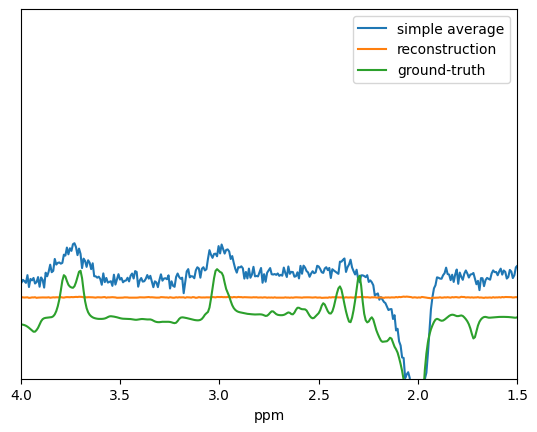

In [ ]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

# creating test dataset and extracting a choosen scan
test_dataset = BasicDataset(x_test,y_test,ppm_test)



sample_x_test,sample_gt_spec,sample_ppm = next(iter(test_dataset))


# calculating simple average of input data
raw_average = sample_x_test.unsqueeze(0).mean(axis=2)

# obtaining output from model
with torch.no_grad():
    pred = model(sample_x_test.unsqueeze(0).float().to(device)).to("cpu")

#plotting all results, with offset between for a better visualization
fig,ax = plt.subplots()

y_offset=0.1

ax.plot(sample_ppm,raw_average.detach().numpy().flatten()+2*y_offset,label="simple average")
ax.plot(sample_ppm,pred.detach().numpy().flatten()+y_offset*1,label="reconstruction")
ax.plot(sample_ppm,sample_gt_spec.detach().numpy().flatten(),label="ground-truth")


ax.set_ylim(-0.3,1.5)
ax.set_xlim(1.5,4)
ax.set_yticks([])
ax.set_xlabel("ppm")
ax.invert_xaxis()

plt.legend()
plt.show()